# Database Export and Import

In [1]:
import os
import numpy as np
import pandas as pd
import emat
from emat.util.show_dir import show_dir
emat.versions()

emat 0.5.0, workbench 2.1.509, plotly 4.12.0


This notebook provides a short walkthrough of exporting data from an
emat database file, and importing raw data into a new database.  For this
walkthrough we'll work in a temporary directory; in real projects you'll
likely want to save your data somewhere less ephemeral.

In [2]:
import tempfile
tempdir = tempfile.TemporaryDirectory()
os.chdir(tempdir.name)

We begin our example by populating a database with some experimental data, by creating and
running a single design of experiments for the Road Test model.

In [3]:
import emat.examples
scope, db, model = emat.examples.road_test()
design = model.design_experiments()
result11 = model.run_experiments(design)

## Single-Design Datasets

When the database has only a single design of experiments, or if we
don't care about any differentiation between multiple designs that we
may have created and ran, we can dump the entire set of model runs,
including uncertainties, policy levers, and performance measures, all
consolidated into a single pandas DataFrame using the 
`read_experiment_all` function.  The constants even appear in this DataFrame
too, for good measure.

In [4]:
df = db.read_experiment_all(scope.name)
df

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,83.038716,101.209566,-18.170849,-124.354513,-238.705390,114.350877,2154.415985
2,60,100,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,88.474313,93.755360,-5.281047,-73.420504,-456.483176,383.062672,12369.380535
3,60,100,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,75.027180,94.166104,-19.138925,-82.150781,-249.724136,167.573355,4468.506839
4,60,100,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,77.370428,93.891545,-16.521117,-340.738378,-640.661724,299.923347,6526.325171
5,60,100,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,88.328990,104.471205,-16.142215,-144.061402,-204.181249,60.119848,2460.910705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,60,100,0.169674,4.939898,150,0.131775,112.348054,0.033034,-0.000120,24.215074,34,Rev Bond,True,135.446332,117.470763,17.975569,355.309103,216.399925,138.909178,2720.516457
107,60,100,0.148297,3.824779,110,0.103255,105.248708,0.033437,0.007041,38.013885,22,GO Bond,True,72.811506,95.358945,-22.547438,-256.095108,-505.886115,249.791007,4000.912327
108,60,100,0.134701,3.627795,144,0.035233,132.063099,0.036702,0.018681,52.155613,32,Paygo,True,90.340993,98.240771,-7.899778,-40.079529,-273.006286,232.926757,6887.831931


Exporting this data is simply a matter of using the usual pandas 
methods to save the dataframe to a format of your choosing.  We'll
save our data into a gzipped CSV file, which is somewhat compressed
(we're not monsters) but still widely compatible for a variety of uses.

In [5]:
df.to_csv("road_test_1.csv.gz")

This table contains most of the information we want to export from
our database, but not everything.  We also probably want to have access
to all of the information in the exploratory scope as well.  Our example
generator gives us a `Scope` reference directly, but if we didn't have that
we can still extract it from the database, using the `read_scope` method.

In [6]:
s = db.read_scope()
s

<emat.Scope with 2 constants, 7 uncertainties, 4 levers, 7 measures>

In [7]:
s.dump(filename="road_test_scope.yaml")

In [8]:
show_dir('.')

/
├── road_test_1.csv.gz
└── road_test_scope.yaml


Now, we're ready to begin anew, constructing a fresh database from scratch,
using only the raw formatted files.

First, let's load our scope from the yaml file, and initialize a clean database
using that scope.

In [9]:
s2 = emat.Scope("road_test_scope.yaml")

In [10]:
db2 = emat.SQLiteDB("road_test.sqldb")

In [11]:
db2.store_scope(s2)

Just as we used pandas to save out our consolidated DataFrame of experimental results,
we can use it to read in a consolidated table of experiments.

In [12]:
df2 = pd.read_csv("road_test_1.csv.gz", index_col='experiment')
df2

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,83.038716,101.209566,-18.170849,-124.354513,-238.705390,114.350877,2154.415985
2,60,100,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,88.474313,93.755360,-5.281047,-73.420504,-456.483176,383.062672,12369.380535
3,60,100,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,75.027180,94.166104,-19.138925,-82.150781,-249.724136,167.573355,4468.506839
4,60,100,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,77.370428,93.891545,-16.521117,-340.738378,-640.661724,299.923347,6526.325171
5,60,100,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,88.328990,104.471205,-16.142215,-144.061402,-204.181249,60.119848,2460.910705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,60,100,0.169674,4.939898,150,0.131775,112.348054,0.033034,-0.000120,24.215074,34,Rev Bond,True,135.446332,117.470763,17.975569,355.309103,216.399925,138.909178,2720.516457
107,60,100,0.148297,3.824779,110,0.103255,105.248708,0.033437,0.007041,38.013885,22,GO Bond,True,72.811506,95.358945,-22.547438,-256.095108,-505.886115,249.791007,4000.912327
108,60,100,0.134701,3.627795,144,0.035233,132.063099,0.036702,0.018681,52.155613,32,Paygo,True,90.340993,98.240771,-7.899778,-40.079529,-273.006286,232.926757,6887.831931


In [13]:
db2.write_experiment_all(
    scope_name=s2.name, 
    design_name='general',
    source=0,
    xlm_df=df2,
)

Time Savings

<xmle.Elem 'img' with 0 children>
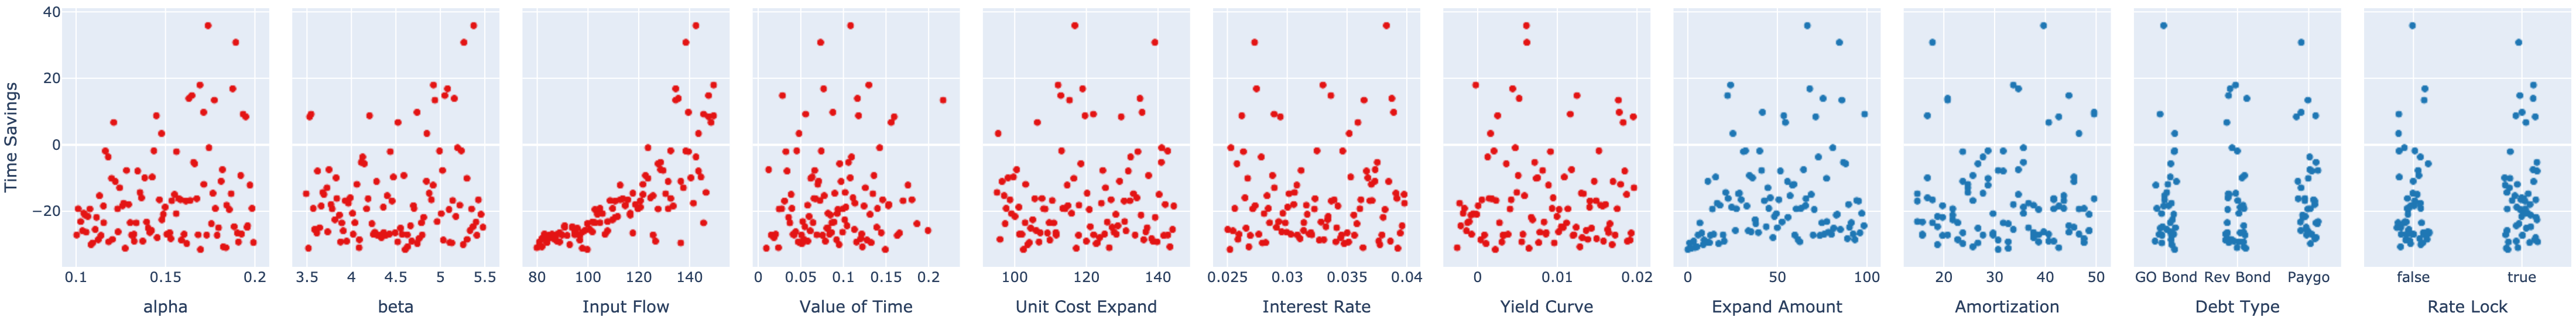

Net Benefits

<xmle.Elem 'img' with 0 children>
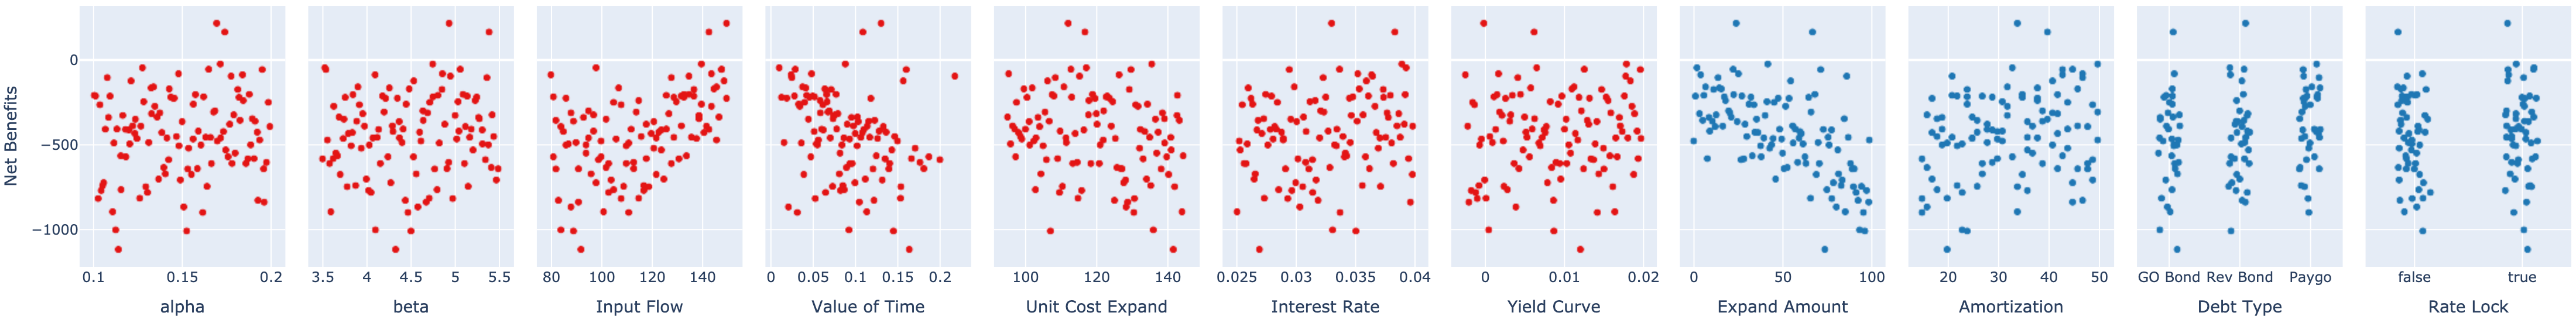

In [14]:
from emat.analysis import display_experiments
display_experiments(s2, 'general', db=db2, rows=['time_savings', 'net_benefits'])

In [15]:
model.allow_short_circuit

True

In [16]:
model.lane_width = 10

In [17]:
result10 = model.run_experiments(design, allow_short_circuit=False)
result10

,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,free_flow_time,initial_capacity,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,60,100,83.038716,69.586789,13.451927,92.059972,-22.290905,114.350877,2154.415985
2,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,60,100,88.474313,62.132583,26.341730,366.219659,-16.843014,383.062672,12369.380535
3,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,60,100,75.027180,62.543328,12.483852,53.584943,-113.988412,167.573355,4468.506839
4,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,60,100,77.370428,62.268768,15.101660,311.462907,11.539561,299.923347,6526.325171
5,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,60,100,88.328990,72.848428,15.480561,138.156464,78.036616,60.119848,2460.910705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.169674,4.939898,150,0.131775,112.348054,0.033034,-0.000120,24.215074,34,Rev Bond,True,60,100,135.446332,85.847986,49.598345,980.371960,841.462782,138.909178,2720.516457
107,0.148297,3.824779,110,0.103255,105.248708,0.033437,0.007041,38.013885,22,GO Bond,True,60,100,72.811506,63.736168,9.075338,103.078214,-146.712793,249.791007,4000.912327
108,0.134701,3.627795,144,0.035233,132.063099,0.036702,0.018681,52.155613,32,Paygo,True,60,100,90.340993,66.617994,23.722999,120.358653,-112.568104,232.926757,6887.831931


In [18]:
result10.select_dtypes('number') - result11.select_dtypes('number')

,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,free_flow_time,initial_capacity,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,-31.622777,31.622777,216.414485,216.414485,0.0,0.0
2,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,-31.622777,31.622777,439.640162,439.640162,0.0,0.0
3,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,-31.622777,31.622777,135.735724,135.735724,0.0,0.0
4,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,-31.622777,31.622777,652.201285,652.201285,0.0,0.0
5,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,-31.622777,31.622777,282.217865,282.217865,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,-31.622777,31.622777,625.062857,625.062857,0.0,0.0
107,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,-31.622777,31.622777,359.173322,359.173322,0.0,0.0
108,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,-31.622777,31.622777,160.438183,160.438183,0.0,0.0


## Multiple-Design Datasets

In [15]:
design_uni = model.design_experiments(sampler='uni')
model.run_experiments(design_uni)
model.run_reference_experiment();

In [16]:
db.read_design_names(s.name)

['lhs', 'ref', 'uni']

In [17]:
df = db.read_experiment_all(scope.name)
df

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,83.038716,69.586789,13.451927,92.059972,-22.290905,114.350877,2154.415985
2,60,100,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,88.474313,62.132583,26.341730,366.219659,-16.843014,383.062672,12369.380535
3,60,100,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,75.027180,62.543328,12.483852,53.584943,-113.988412,167.573355,4468.506839
4,60,100,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,77.370428,62.268768,15.101660,311.462907,11.539561,299.923347,6526.325171
5,60,100,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,88.328990,72.848428,15.480561,138.156464,78.036616,60.119848,2460.910705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,60,100,0.150000,4.000000,100,0.075000,100.000000,0.030000,0.010000,0.000000,15,GO Bond,False,69.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000
128,60,100,0.150000,4.000000,100,0.075000,100.000000,0.030000,0.010000,0.000000,50,GO Bond,False,69.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000
129,60,100,0.150000,4.000000,100,0.075000,100.000000,0.030000,0.010000,0.000000,30,Rev Bond,False,69.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
model.function

<function emat.model.core_python.core_python_examples.Road_Capacity_Investment(free_flow_time=60, initial_capacity=100, alpha=0.15, beta=4.0, input_flow=100, value_of_time=0.01, unit_cost_expansion=1, interest_rate=0.03, yield_curve=0.01, expand_capacity=10, amortization_period=30, interest_rate_lock=False, debt_type='GO Bond', lane_width=10, **kwargs)>

In [22]:
model.function_ = model.function
def corrupt(*args, **kwargs): 
    return model.function_(*args, **kwargs, lane_width=11)
model.function = corrupt

## Managing Mistakes